<a href="https://colab.research.google.com/github/rinermdhn/Market-Basket-Analysis/blob/main/%5BAssociation_Rule%5D_Market_Basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data






## Import Package

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import textwrap
import math
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## Importing Dataset

In [ ]:

# Link URL dari spreadsheet
url = 'https://docs.google.com/spreadsheets/d/1DB7qc3NuYthHrDA4Km1LqYbf2Q76j9rI/edit?usp=sharing'

# Ubah URL menjadi format export CSV
csv_url = url.replace('/edit?usp=sharing', '/export?format=csv')

# Baca data menggunakan pandas
df = pd.read_csv(csv_url)

# Tampilkan beberapa baris pertama
print(df.head())
df


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate UnitPrice  CustomerID         Country  
0  12/1/10 8:26      2,55     17850.0  United Kingdom  
1  12/1/10 8:26      3,39     17850.0  United Kingdom  
2  12/1/10 8:26      2,75     17850.0  United Kingdom  
3  12/1/10 8:26      3,39     17850.0  United Kingdom  
4  12/1/10 8:26      3,39     17850.0  United Kingdom  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,"2,55",17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,"3,39",17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,"2,75",17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,"3,39",17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,"3,39",17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,"0,85",12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,"2,1",12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,"4,15",12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,"4,15",12680.0,France


Dari percobaan-percobaan yang kita lakukan, dapat kita simpulkan bahwa data yang diberikan:
1. Sudah cukup baik dan lengkap, karena tidak ditemukan adanya typo pada semua kolom.
2. Sampel data yang diberikan juga sangat banyak sehingga kemungkinan besar intepretasi yang dihasilkan sesuai dengan kenyataan.
3. Claimnya pada data tersebut sudah bersih dari missing value, tetapi akan tetap dilakukan pengecekan missing value untuk memastikan.



# Pre-processing & Data Understanding

In [ ]:
#Akan di cek tipe data
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,object
CustomerID,float64
Country,object


Hasilnya menunjukkan bahwa sebagian besar kolom, seperti InvoiceNo, StockCode, Description, InvoiceDate, UnitPrice, dan Country, bertipe object yang biasanya merepresentasikan teks atau data campuran. Kolom Quantity bertipe int64, menunjukkan bahwa data di dalamnya berupa bilangan bulat. Sementara itu, CustomerID bertipe float64 yang berarti berisi angka desimal. Hal ini terjadi kemungkinan karena adanya nilai kosong atau kesalahan format. Selain itu, teridentifikasinya InvoiceDate dan UnitPrice sebagai object juga bisa menjadi masalah karena tanggal seharusnya dikonversi ke datetime dan harga ke float agar lebih mudah dianalisis. Oleh karena itu pada langkah selanjutnya akan dilakukan pengubahan tipe data.

In [ ]:
# Mengubah 'InvoiceDate' menjadi tipe datetime lengkap (tanggal dan waktu)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce', infer_datetime_format=True)

# Ubah tipe data Unitprice
df['UnitPrice'] = df['UnitPrice'].replace(',', '.', regex=True).astype(float)

# Ubah tipe data CustomerID
df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce').astype('Int64')

In [ ]:
#Akan di cek tipe data setelah diubah tipe datanya
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,Int64
Country,object


Berikut adalah tipe dataset setelah beberapa kolom, yang sebelumnya tipenya tidak tepat, telah dikonversi ke tipe data yang lebih tepat. InvoiceDate berhasil diubah menjadi datetime64[ns] agar memungkinkan pengolahan data waktu menjadi lebih akurat. UnitPrice dikonversi menjadi float64 setelah menghilangkan karakter titik desimal agar dapat merepresentasikan harga dengan benar. CustomerID, yang sebelumnya float64, diubah menjadi Int64 untuk menangani ID pelanggan sebagai bilangan bulat sambil tetap mengizinkan nilai kosong (NaN). Hal ini dilakukan untuk memastikan data memiliki tipe yang sesuai untuk analisis lebih lanjut.

## Handling Missing Value

In [ ]:
# Cek apakah ada data yang hilang (Missing Value)
print(df.isnull().sum())
df[df.isna().any(axis=1)]

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,<NA>,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,<NA>,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,<NA>,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,<NA>,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,<NA>,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,<NA>,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,<NA>,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,<NA>,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,<NA>,United Kingdom


Hasilnya menunjukkan bahwa terdapat missing values pada beberapa kolom seperti pada kolom Description yang memiliki 1.454 missing values dan CustomerID yang memiliki 135.080 missing values. Dari hasil tersebut, akan dianalisis lebih lanjut mengenai faktor penyebab adanya missing value.

Analisis missing value yang pertama akan dilakukan pada kolom CustomerID. Akan dilakukan pengecekan dari sisi kolom InvoiceNo untuk melihat apakah untuk observasi yang terdeteksi memiliki missing value pada CustomerID, terdapat observasi lain yang memiliki InvoiceNo yang sama tetapi CustomerID nya non-NaN.

In [ ]:
invoices_with_nan_customer = df[df['CustomerID'].isna()]['InvoiceNo'].unique()
found = False

for invoice in tqdm(invoices_with_nan_customer, desc="Memeriksa InvoiceNo"):
    rows_with_customer = df[(df['InvoiceNo'] == invoice) & (df['CustomerID'].notna())]

    if not rows_with_customer.empty:
        for index, row in rows_with_customer.iterrows():
            print(f"InvoiceNo: {invoice}, CustomerID: {row['CustomerID']}")
        found = True

if not found:
    print("Tidak ada InvoiceNo yang memiliki CustomerID tidak hilang.")

Memeriksa InvoiceNo: 100%|██████████| 3710/3710 [03:27<00:00, 17.87it/s]

Tidak ada InvoiceNo yang memiliki CustomerID tidak hilang.


Dari output di atas, didapatkan bahwa pada setiap InvoiceNo yang terdeteksi memiliki CustomerID yang NaN (hilang), tidak dapat ditemukan versi lain dari InvoiceNo yang sama yang memiliki CustomerID non-NaN di dataset. Akan tetapi, karena analisis Market Basket Analysis (MBA) yang nantinya akan dilakukan tidak terlalu bergantung dengan CustomerID melainkan lebih kepada pola belanja pelanggan maka tidak akan dilakukan drop data pada observasi yang memiliki missing value pada kolom CustomerID ini. Hal ini dilakukan untuk mempertahankan konsistensi pola data penjualannya dan observasi yang memiliki missing value pada kolom CustomerID akan dianggap sebagai pembeli anonim.

In [ ]:
df[df['Description'].isna()]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,<NA>,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,<NA>,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,<NA>,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,<NA>,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,<NA>,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07 18:26:00,0.0,<NA>,United Kingdom
535326,581203,23406,NaN,15,2011-12-07 18:31:00,0.0,<NA>,United Kingdom
535332,581209,21620,NaN,6,2011-12-07 18:35:00,0.0,<NA>,United Kingdom
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,<NA>,United Kingdom


Akan dilakukan pengecekan dari sisi kolom StockCode untuk melihat apakah untuk observasi yang terdeteksi memiliki missing value pada Description, terdapat observasi lain yang memiliki StockCode yang sama tetapi CustomerID nya non-NaN.

In [ ]:
stockcode_with_nan_description = df[df['Description'].isna()]['StockCode'].unique()
found = False

description_dict = {}

for stockcode in tqdm(stockcode_with_nan_description, desc="Checking StockCode"):
    rows_with_description = df[(df['StockCode'] == stockcode) & (df['Description'].notna())]

    if not rows_with_description.empty:
        found = True
        unique_descriptions = set(rows_with_description['Description'])
        description_dict[stockcode] = unique_descriptions

if found:
    for stockcode, descriptions in description_dict.items():
        print(f'STOCK CODE: {stockcode}, Unique Description = {descriptions}')
else:
    print("Tidak ada StockCode yang memiliki Description tidak hilang.")

Checking StockCode: 100%|██████████| 960/960 [01:21<00:00, 11.83it/s]

STOCK CODE: 22139, Unique Description = {'amazon', 'RETROSPOT TEA SET CERAMIC 11 PC '}
STOCK CODE: 22145, Unique Description = {'CHRISTMAS CRAFT HEART STOCKING '}
STOCK CODE: 37509, Unique Description = {'NEW ENGLAND MUG W GIFT BOX'}
STOCK CODE: 37461, Unique Description = {'FUNKY MONKEY MUG'}
STOCK CODE: 21777, Unique Description = {'RECIPE BOX WITH METAL HEART'}
STOCK CODE: 84952C, Unique Description = {'MIRROR LOVE BIRD T-LIGHT HOLDER'}
STOCK CODE: 22712, Unique Description = {'CARD DOLLY GIRL '}
STOCK CODE: 22028, Unique Description = {'PENNY FARTHING BIRTHDAY CARD'}
STOCK CODE: 85067, Unique Description = {'CREAM SWEETHEART WALL CABINET'}
STOCK CODE: 21421, Unique Description = {'damaged', 'PORCELAIN ROSE LARGE '}
STOCK CODE: 21414, Unique Description = {'SCALLOP SHELL SOAP DISH'}
STOCK CODE: 21651, Unique Description = {'HANGING GLASS ETCHED TEALIGHT'}
STOCK CODE: 85126, Unique Description = {'LARGE ROUND CUTGLASS CANDLESTICK'}
STOCK CODE: 21814, Unique Description = {'HEART T-LI

Langkah tersebut berfungsi untuk menemukan dan mencocokkan StockCode yang memiliki deskripsi kosong (NaN) dengan deskripsi valid yang ada pada baris lain di dataset. Hal ini dilakukan dengan mencari StockCode dengan deskripsi kosong, lalu untuk setiap StockCode tersebut, dicari baris lain yang memiliki StockCode sama namun deskripsinya tidak kosong. Jika ditemukan, semua deskripsi unik untuk StockCode tersebut disimpan dalam dictionary.

Dari hasilnya, didapatkan bahwa banyak missing value pada kolom Description telah berhasil diisi. Akan tetapi, ditemukan kesalahan-kesalahan seperti tercatat lebih dari satu nama produk dan terdapat input nama yang tidak valid (check, ??, ? sold as sets?, dll).

In [ ]:
df[df['StockCode'] == '85175']['Description'].value_counts()

,count
Description,
CACTI T-LIGHT CANDLES,148
Amazon sold sets,1
dotcom sold sets,1
wrongly sold sets,1
? sold as sets?,1
check,1


Berikut adalah salah satu contoh observasi yang terdapat kesalahan pada kolom Description seperti yang disebutkan diatas, yaitu tercatat lebih dari satu nama produk dan terdapat input nama yang tidak valid (check, ??, ? sold as sets?, dll). Oleh karena itu, pada langkah selanjutnya akan dilakukan koreksi terhadap kolom Description.

In [ ]:
unique_stock_codes = df['StockCode'].unique()
most_frequent_desc_dict = {}

for stock_code in tqdm(unique_stock_codes, desc="Finding Most Frequent Descriptions"):
    descriptions = df[df['StockCode'] == stock_code]['Description']

    if not descriptions.isna().all():
        most_frequent_desc = descriptions.value_counts().idxmax()
        most_frequent_desc_dict[stock_code] = most_frequent_desc

for stock_code, most_frequent_desc in tqdm(most_frequent_desc_dict.items(), desc="Replacing Descriptions"):
    df.loc[df['StockCode'] == stock_code, 'Description'] = most_frequent_desc

Replacing Descriptions: 100%|██████████| 3958/3958 [03:49<00:00, 17.22it/s]


Dilakukan standarisasi Description berdasarkan StockCode dengan cara mengganti semua deskripsi untuk setiap StockCode dengan deskripsi yang paling sering muncul di StockCode tersebut. Hal ini berguna untuk membersihkan data yang tidak konsisten atau mengandung nilai kosong (NaN) pada kolom Description. Dengan proses ini, setiap StockCode akan memiliki deskripsi seragam, yang memudahkan analisis dan mencegah inkonsistensi data.

In [ ]:
df[df['Description'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,<NA>,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,<NA>,United Kingdom
1988,536550,85044,NaN,1,2010-12-01 14:34:00,0.0,<NA>,United Kingdom
2024,536552,20950,NaN,1,2010-12-01 14:34:00,0.0,<NA>,United Kingdom
2026,536554,84670,NaN,23,2010-12-01 14:35:00,0.0,<NA>,United Kingdom
...,...,...,...,...,...,...,...,...
280754,561498,21610,NaN,-14,2011-07-27 14:10:00,0.0,<NA>,United Kingdom
281615,561555,37477B,NaN,-11,2011-07-28 10:21:00,0.0,<NA>,United Kingdom
281616,561557,37477C,NaN,-31,2011-07-28 10:21:00,0.0,<NA>,United Kingdom
346849,567207,35592T,NaN,4,2011-09-19 11:01:00,0.0,<NA>,United Kingdom


Dari hasilnya, didapatkan bahwa masih terdeteksi missing value pada kolom Description sebanyak 112.

In [ ]:
df[df['StockCode'] == '21134']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,<NA>,United Kingdom


Kemudian dilakukan pengecekan terhadap observasi yang masih memiliki missing value tersebut. Didapatkan bahwa observasi-observasi tersebut memang tidak memiliki nama produk.

In [ ]:
unique_counts = df.groupby('StockCode')['Description'].nunique()

stock_codes_with_multiple_uniques = unique_counts[unique_counts > 1]

if not stock_codes_with_multiple_uniques.empty:
    print("Stock Codes with multiple unique descriptions:")
    for stock_code in stock_codes_with_multiple_uniques.index:
        unique_descriptions = df[df['StockCode'] == stock_code]['Description'].unique()
        print(f"Stock Code: {stock_code}, Unique Descriptions: {unique_descriptions}")
else:
    print("No Stock Code has more than one unique description.")


No Stock Code has more than one unique description.


Setelah itu, dilakukan pengecekan untuk melihat apakah masih terdapat StockCode yang memiliki lebih dari satu deskripsi unik. Output-nya menunjukkan hasil yang bagus, dimana didapatkan bahwa tidak ada StockCode yang memiliki lebih dari satu deskripsi unik,

In [ ]:
print('Produk yang Tersedia :' , len(df['Description'].unique()))
print('List Produk :')
list(df['Description'].unique())

Produk yang Tersedia : 3824
List Produk :


['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED RETROSPOT',
 'ASSORTED COLOUR BIRD ORNAMENT',
 "POPPY'S PLAYHOUSE BEDROOM ",
 "POPPY'S PLAYHOUSE KITCHEN",
 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 'IVORY KNITTED MUG COSY ',
 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 'BOX OF VINTAGE JIGSAW BLOCKS ',
 'BOX OF VINTAGE ALPHABET BLOCKS',
 'HOME BUILDING BLOCK WORD',
 'LOVE BUILDING BLOCK WORD',
 'RECIPE BOX WITH METAL HEART',
 'DOORMAT NEW ENGLAND',
 'JAM MAKING SET WITH JARS',
 'RED COAT RACK PARIS FASHION',
 'YELLOW COAT RACK PARIS FASHION',
 'BLUE COAT RACK PARIS FASHION',
 'BATH BUILDING BLOCK WORD',
 'ALARM CLOCK BAKELIKE PINK',
 'ALARM CLOCK BAKELIKE RED ',
 'ALARM CLOCK BAKELIKE GREEN',
 'PANDA AND BUNNIES STICKER SHEET',
 'STARS GIFT TAPE ',
 'INFLATAB

Selanjutnya, akan dilakukan pengecekan untuk melihat apakah terdapat StockCode yang berbeda akan tetapi memiliki Description yang sama.

In [ ]:
duplicate_descriptions = df.groupby('Description')['StockCode'].nunique()
duplicate_descriptions = duplicate_descriptions[duplicate_descriptions > 1]

print("Descriptions with Different Stock Codes:")
for description in duplicate_descriptions.index:
    stock_codes = df[df['Description'] == description]['StockCode'].unique()
    print(f"Description: {description}, Stock Codes: {list(stock_codes)}")


Descriptions with Different Stock Codes:
Description: 3 GARDENIA MORRIS BOXED CANDLES, Stock Codes: ['85034A', '85034a']
Description: 3 WHITE CHOC MORRIS BOXED CANDLES, Stock Codes: ['85034B', '85034b']
Description: 3D DOG PICTURE PLAYING CARDS, Stock Codes: ['84558A', '84558a']
Description: 3D SHEET OF CAT STICKERS, Stock Codes: ['84559B', '84559b']
Description: 3D SHEET OF DOG STICKERS, Stock Codes: ['84559A', '84559a']
Description: 4 ROSE PINK DINNER CANDLES, Stock Codes: ['72801C', '72801c']
Description: 4 SKY BLUE DINNER CANDLES, Stock Codes: ['72801D', '72801d']
Description: 75 GREEN FAIRY CAKE CASES, Stock Codes: ['84989a', '84989A']
Description: 75 GREEN PETIT FOUR CASES, Stock Codes: ['84993A', '84993a']
Description: ANT WHITE WIRE HEART SPIRAL, Stock Codes: ['84884A', '84884a']
Description: BISCUITS SMALL BOWL LIGHT BLUE, Stock Codes: ['84596L', '84596l']
Description: BLACK CHUNKY BEAD BRACELET W STRAP, Stock Codes: ['90184C', '90184c']
Description: BLACK DROP EARRINGS W LONG

Output-nya menunjukkan bahwa terdapat StockCode yang berbeda tetapi memiliki nama yang sama. Akan tetapi, ditemukan banyak kasus dimana perbedaannya hanya terdapat pada besar kecil huruf yang terdapat pada StockCode tersebut. Oleh karena itu, untuk mengatasi masalah pada kasus ini akan dilakukan standarisasi StockCode.

In [ ]:
descriptions_with_two_stockcodes = df.groupby('Description')['StockCode'].nunique()
descriptions_with_two_stockcodes = descriptions_with_two_stockcodes[descriptions_with_two_stockcodes == 2]

for description in tqdm(descriptions_with_two_stockcodes.index, desc="Standardizing Stock Codes"):
    stock_codes = df[df['Description'] == description]['StockCode'].unique()

    if len(stock_codes) == 2:
        df.loc[df['Description'] == description, 'StockCode'] = df.loc[df['Description'] == description, 'StockCode'].str.upper()

print("Stock Codes with 2 unique values have been standardized to uppercase.")


Standardizing Stock Codes: 100%|██████████| 121/121 [00:18<00:00,  6.55it/s]

Stock Codes with 2 unique values have been standardized to uppercase.


Dilakukan standarisasi StockCode dengan mengubah semua huruf menjadi huruf kapital. Hal ini untuk memastikan bahwa setiap produk memiliki kode konsisten dan menghindari duplikasi yang tidak disengaja.

In [ ]:
df[df['Description'] == 'WHITE HANGING HEART T-LIGHT HOLDER']['StockCode'].unique()

array(['85123A'], dtype=object)

Dari hasilnya, didapatkan bahwa penulisan StockCode sudah benar.

In [ ]:
duplicate_descriptions = df.groupby('Description')['StockCode'].nunique()
duplicate_descriptions = duplicate_descriptions[duplicate_descriptions > 1]

print("Descriptions with Different Stock Codes:")
for description in duplicate_descriptions.index:
    stock_codes = df[df['Description'] == description]['StockCode'].unique()
    print(f"Description: {description}, Stock Codes: {list(stock_codes)}")


Descriptions with Different Stock Codes:
Description: COLOURING PENCILS BROWN TUBE, Stock Codes: ['10133', '10135']
Description: COLUMBIAN CANDLE RECTANGLE, Stock Codes: ['72133', '72131']
Description: COLUMBIAN CANDLE ROUND, Stock Codes: ['72130', '72128']
Description: EAU DE NILE JEWELLED PHOTOFRAME, Stock Codes: ['85023B', '85024B']
Description: FRENCH FLORAL CUSHION COVER , Stock Codes: ['20840', '20837']
Description: FRENCH LATTICE CUSHION COVER , Stock Codes: ['20835', '20838']
Description: FROSTED WHITE BASE , Stock Codes: ['79403', '79406']
Description: METAL SIGN,CUPCAKE SINGLE HOOK, Stock Codes: ['82613B', '82613C', '82613A', '82613b', '82613c', '82613a']
Description: PINK FAIRY CAKE CUSHION COVER, Stock Codes: ['47586A', '47585A']
Description: PINK FLOCK GLASS CANDLEHOLDER, Stock Codes: ['79329', '79331']
Description: PINK FLOWERS RABBIT EASTER, Stock Codes: ['35909B', '35910B']
Description: RETRO PLASTIC 70'S TRAY, Stock Codes: ['79190A', '79192A']
Description: RETRO PLASTI

Kemudian dilakukan pengecekan ulang untuk melihat apakah masih terdapat StockCode yang berbeda akan tetapi memiliki Description yang sama. Hasilnya menunjukkan bahwa masih terdapat beberapa StockCode yang berbeda tetapi memiliki Description yang sama. Dalam kasus ini, tidak akan dilakukan penindakan lebih lanjut selagi penamaan Description nya sama dan penulisan StockCode nya sudah benar.

In [ ]:
df = df.dropna()

Selanjutnya, dilakukan drop pada missing value.

In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [ ]:
df['Description'] = df['Description'].str.title()
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,White Hanging Heart T-Light Holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,White Metal Lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,Cream Cupid Hearts Coat Hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,Knitted Union Flag Hot Water Bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,Red Woolly Hottie White Heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,Pack Of 20 Spaceboy Napkins,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,Children'S Apron Dolly Girl,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,Childrens Cutlery Dolly Girl,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,Childrens Cutlery Circus Parade,4,2011-12-09 12:50:00,4.15,12680,France


Kolom Description akan diubah menjadi Title Case untuk setiap entri dengan tujuan membuat data lebih konsisten dan rapi.

In [ ]:
invoice_customer_counts = df.groupby('InvoiceNo')['CustomerID'].nunique()
invoices_with_multiple_customers = invoice_customer_counts[invoice_customer_counts > 1]

if not invoices_with_multiple_customers.empty:
    for invoice in tqdm(invoices_with_multiple_customers.index, desc="Checking Invoices"):
        customer_ids = df[df['InvoiceNo'] == invoice]['CustomerID'].unique()
        print(f"InvoiceNo: {invoice}, CustomerIDs: {customer_ids}")
else:
    print("No InvoiceNumber has more than one unique CustomerID.")

No InvoiceNumber has more than one unique CustomerID.


Dari output di atas didapatkan bahwa tidak terdapat InvoiceNo yang memiliki lebih dari satu CustomerID.

Selanjutnya, pada saat pengecekan kolom Description ditemukan bahwa terdapat Quantity yang bernilai negatif. Sehingga semua nilai Quantity diubah menjadi nilai absolut (positif). Hal ini dilakukan karena nilai negatif tidak logis untuk transaksi penjualan.

In [ ]:
df['Quantity'] = np.abs(df['Quantity'] )

Kemudian akan dilihat rentang nilai dari kolom Quantity.

In [ ]:
print('interval :', '(' , df['Quantity'].min() , ',',  df['Quantity'].max() , ')')

interval : ( 1 , 80995 )


Didapatkan hasilnya menunjukkan bahwa setelah perubahan, nilai Quantity berkisar antara 1 hingga 80.995. Oleh karena itu, akan dilakukan pengecekan outlier pada langkah selanjutnya.


<Axes: xlabel='Quantity'>

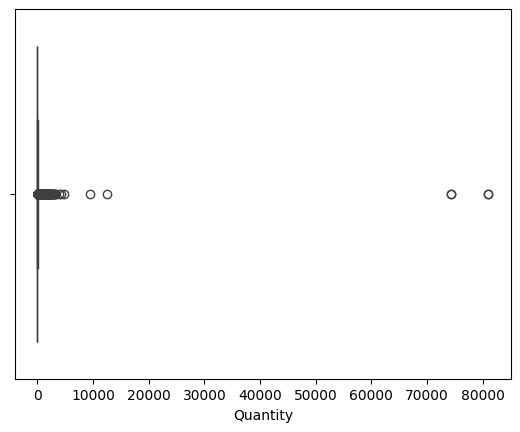

In [ ]:
sns.boxplot(x='Quantity' , data=df)

Setelah dilakukan pengecekan terhadap outlier pada data, ditemukan bahwa banyak terdapat banyak transaksi yang memiliki Quantity lebih dari seribu. Hal ini kurang logis untuk satu transaksi belanja online. Oleh karena itu akan diambil data dengan Quantity kurang dari tiga ratus untuk digunakan dalam analisis lebih lanjut. Didapatkan data akhirnya dengan 405926 baris dan 8 kolom.

In [ ]:
df_final = df[df['Quantity'] <= 300]

In [ ]:
df_final

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,White Hanging Heart T-Light Holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,White Metal Lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,Cream Cupid Hearts Coat Hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,Knitted Union Flag Hot Water Bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,Red Woolly Hottie White Heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,Pack Of 20 Spaceboy Napkins,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,Children'S Apron Dolly Girl,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,Childrens Cutlery Dolly Girl,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,Childrens Cutlery Circus Parade,4,2011-12-09 12:50:00,4.15,12680,France


In [ ]:
df_final.shape

(405926, 8)

# Visualisasi Data (EDA)

Akan dilakukan Ekplorasi dan Visualisasi data (EDA) untuk mengetahui hubungan dari beberapa kategorik data dengan penjualan produk. Akan dicari hubungan antara jenis produk dan  pembelian:


#### **Jumlah item yang paling banyak dibeli**


Akan dicari hubungan antara jenis produk dan jumlah pembelian

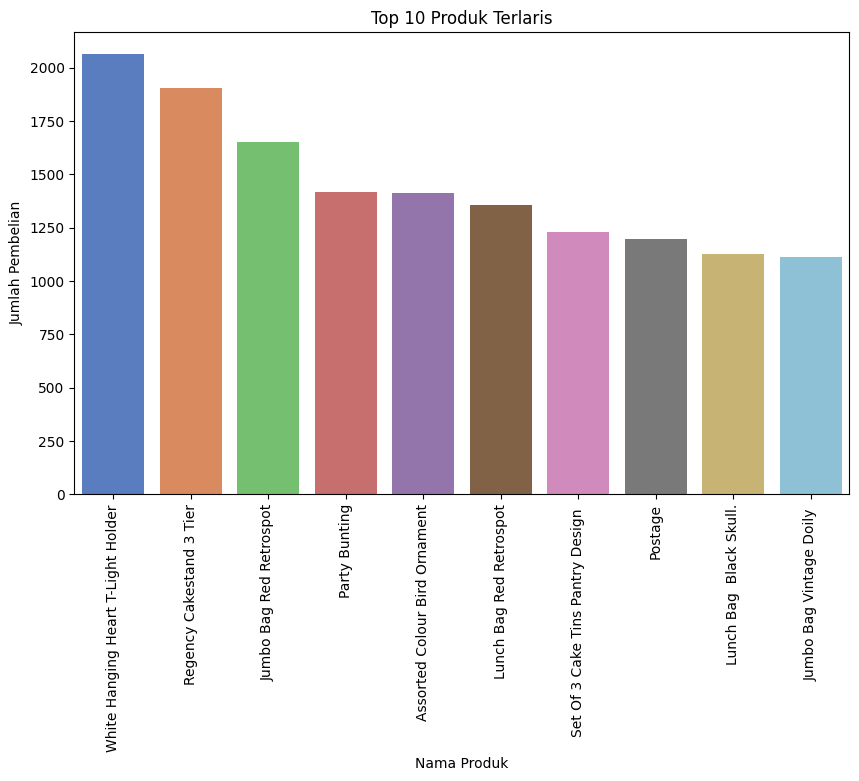

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung frekuensi masing-masing produk
top_items = df_final['Description'].value_counts().nlargest(10)

# Membuat plot berdasarkan 10 item terbesar
plt.figure(figsize=(10,6))
p = sns.barplot(x=top_items.index, y=top_items.values, palette='muted')
# Memberikan label pada plot
plt.xticks(rotation=90)
plt.xlabel('Nama Produk')
plt.ylabel('Jumlah Pembelian')
plt.title('Top 10 Produk Terlaris')
plt.show()




Berdasarkan plot diatas, didapat informasi sebagai berikut :
- White Hanging Heart T-Light Holder adalah produk terlaris yang dibeli oleh konsumen dengan jumlah pembelian lebih dari 2000 item.
- Regency Cakestand 3 tier merupakan produk terlaris kedua dengan pembelian sebanyakn 1900 item.
- Produk ketiga dengan penjualan tertinggi adalah Jumbo Bag Red Retrospot, dengan total pembelian sebanyak 1700 item
- Produk lain seperti Party Bunting, Assorted Colour Bird Ornament, Lunch Bag Red Retrospot, Set of 3 Cake Tins Pantry Design, dan Postage memiliki jumlah pembelian antara 1200 hingga 1400 item
- Lunch Bag Black Skull, dan Jumbo Bad Vintage Doily adalah produk dengan jumlah pembelian terendah dengan sekitar 1100 item


Berdasarkan hasil diatas, kita dapatkan bahwa selisih antara jumlah produk dengan jumlah pembelian terbanyak dan tersedikit tidak terlalu besar. oleh karena itu, dapat disimpulkan bahwa penjualan semua produk sudah cukup merata.


Pertimbangan strategi pemasaran yang dapat digunakan adalah dengan mempertahankan stok produk seperti White Hanging Heart T-Light Holder karena produk tersebut merupakan produk yang terlaris. Sedangkan, kita bisa mengurangi stok atau meningkatkan promosi untuk produk yang paling sedikit pembeliannya seperti Lunch Bag Black Skull dan Jumbo Bag Vintage Doily.


#### **Jumlah pembelian terbanyak berdasarkan negara**



Text(0, 0.5, 'Number of Purchases')

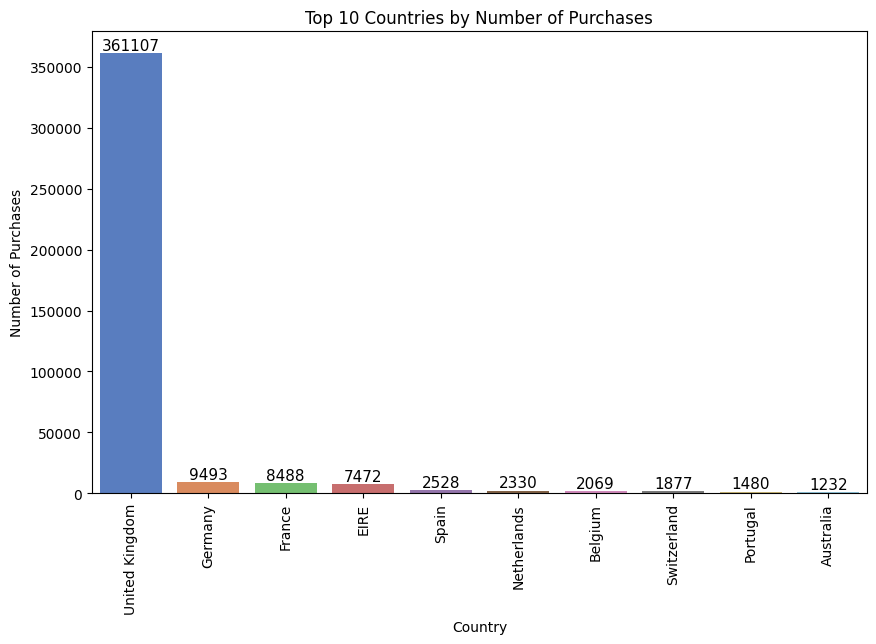

In [ ]:
# Menghitung jumlah pembelian berdasarkan negara
country_sales = df_final['Country'].value_counts().nlargest(10)

# Membuat bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=country_sales.index, y=country_sales.values, palette='muted')

# Menambahkan label di atas setiap batang
for i, value in enumerate(country_sales.values):
    plt.text(i, value + 50, f'{value}', ha='center', va='bottom', fontsize=11)

# Menambahkan rotasi pada label sumbu x dan judul
plt.xticks(rotation=90)
plt.title('Top 10 Countries by Number of Purchases')
plt.xlabel('Country')
plt.ylabel('Number of Purchases')

Berdasarkan plot diatas, didapat beberapa informasi mengenai jumlah pembelian di beberapa negara sebagai berikut :
1. Negara dengan pembelian produk terbanyak adalah United Kingdom dengan total pembelian sebanyak 361.617 kali pembelian
2. Germany, France, dan Eire adalah negara yang menempati urutan ke-2, 3, dan 4 secara berturut- turut dengan jumlah pembelian produk terbanyak di kisaran 7500-9500 kali pembelian
3. Negara lainnya seperti Spain, Netherlands, Belgium, Switzerland, Portugal, dan Australia memiliki total pembelian produk dengan angka yang sangat rendah yakni di kisaran 1200-2500 kali pembelian

Berdasarkan analisis diatas, diperoleh bahwa terdapat selisih yang sangat besar antara United Kingdom sebagai negara dengan jumlah pembelian produk terbanyak dan negara negara lainnya. hal ini menunjukkan bahwa terdapat variasi yang sangat besar dalam kategori ini.

Strategi penjualan yang disarankan adalah dengan menambah stok penjualan di United Kingdom sebagai target pemasaran dan mengurangi stok pada negara negara lain.


#### **Total Pendapatan per Produk**

Total pendapatan bisa dihitung dari Quantity * UnitPrice.

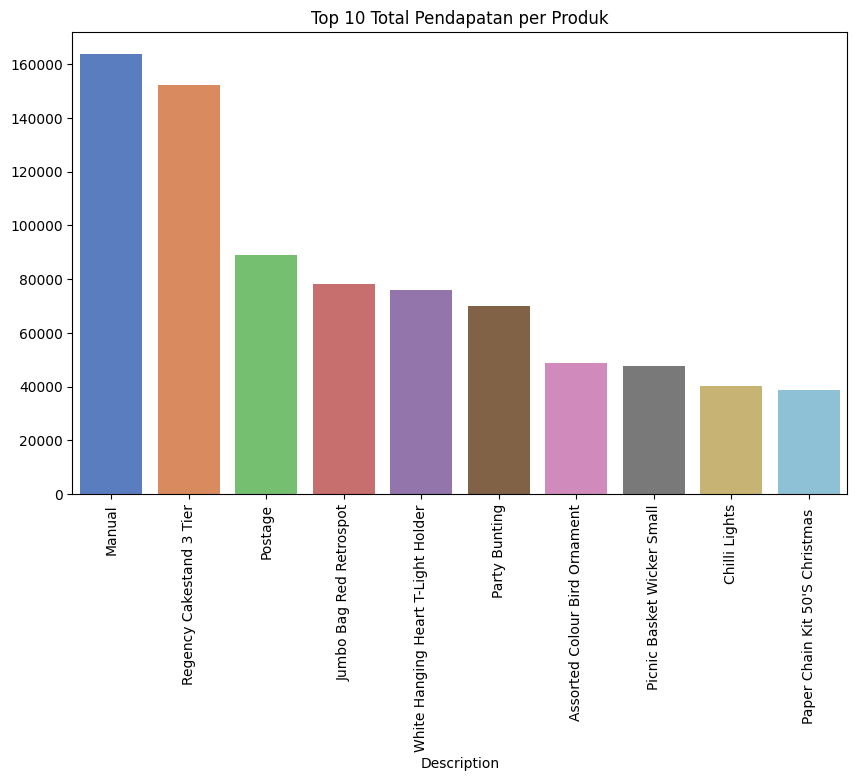

In [ ]:
# Calculate 'TotalSales' and assign it to df_final
df_final['TotalSales'] = df_final['Quantity'] * df['UnitPrice'] # Changed df to df_final

# Now you can group by 'Description' and aggregate 'TotalSales'
top_revenue_items = df_final.groupby('Description')['TotalSales'].sum().nlargest(10)

# The rest of the code should work as expected
plt.figure(figsize=(10,6))
sns.barplot(x=top_revenue_items.index, y=top_revenue_items.values, palette='muted')
plt.xticks(rotation=90)
plt.title('Top 10 Total Pendapatan per Produk')
plt.show()

Berdasarkan plot diatas, didapat informasi sebagai berikut :
1. Produk “Manual” memiliki total pendapatan terbesar dengan $160.000

2. Produk dengan total pendapatan terbesar kedua adalah produk “Regency Cakestand 3 Tier” dengan total pendapatan sebanyak $150.000

3. “Postage”, “Jumbo Bag Red Retrospot”, “White Hanging Heart T-Light Holder”, dan “Party Bunting” memiliki total pendapatan yang cenderung merata yakni di kisaran $70.000 - $90.000

4. Produk seperti “Assorted Colour Bird Ornament”, “Picnic Basket Wicker Small”, “Chilli Lights”, dan “Paper Chain Kit 50’s Christmas” memiliki total pendapatan yang cukup rendah dibanding produk lain yang berada di kisaran angka $40.000 - $50.000

Berdasarkan informasi diatas, didapat selisih dari jumlah pendapatan yang cukup besar antara  produk dengan pendapatan tertinggi dan produk dengan jumlah pendapatan terendah. Hal ini menunjukkan bahwa terdapat variasi yang cukup besar pada kategori tersebut.

Saran agar bisa mendapatkan pendapatan yang optimal adalah meningkatkan penjualan produk “Manual” dan “Regency Cakestand 3 Tier” karena kedua produk tersebut menghasilkan pendapatan tertinggi dibandingkan produk yang lain. Selain itu, untuk mengoptimalkan pendapatan dari produk lain bisa dilakukan dengan cara meningkatkan promosi serta kualitas produk agar bisa mencapai total pendapatan yang optimal.



#### **Analisis Waktu (InvoiceDate)**

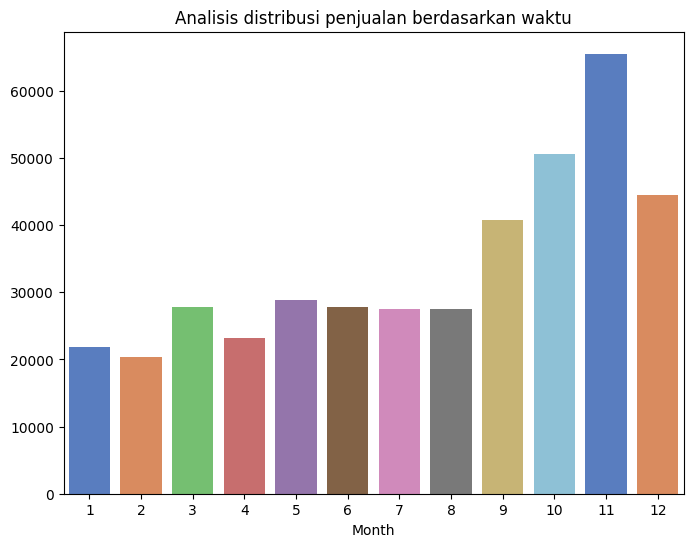

In [ ]:
# Mengambil bulan dari InvoiceDate
df_final['Month'] = pd.to_datetime(df_final['InvoiceDate']).dt.month
monthly_sales = df_final['Month'].value_counts().sort_index()

plt.figure(figsize=(8,6))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values, palette='muted')
plt.title('Analisis distribusi penjualan berdasarkan waktu')
plt.show()


Berdasarkan plot diatas, didapat informasi sebagai berikut :
1. Jumlah penjualan tertinggi dicapai pada saat bulan ke-11 yakni bulan November dengan total jumlah penjualan sebanyak hampir 70.000 produk
2. Jumlah penjualan tertinggi kedua dicapai pada saat bulan ke-10 yakni bulan Oktober dengan total jumlah penjualan sebanyak 50.000 produk
3. Total jumlah penjualan pada bulan desember dan september hampir sama yakni berada pada kisaran 40.000 - 45.000 produk
4. Sedangkan, penjualan pada bulan - bulan yang lain terlihat hampir sama yakni berada pada kisaran 20.000 - 30.000 produk

Berdasarkan informasi yang didapat, dapat disimpulkan bahwa konsumen cenderung lebih banyak membeli produk pada akhir tahun. hal ini bisa dilihat dari perbedaan atau selisih angka penjualan pada bulan “September”, “Oktober”, “November”, dan “Desember” dengan bulan lainnya.

Saran agar bisa mendapatkan keuntungan optimal adalah dengan lebih memfokuskan dan meningkatkan penjualan pada akhir tahun. selain itu, kita bisa menerapkan diskon awal tahun atau promo pada pertengahan tahun untuk bisa meningkatkan jumlah pendapatan pada setiap bulannya sehingga penjualan akan lebih merata di sepanjang tahun.


### **Frekuensi Pelanggan (CustomerID)**

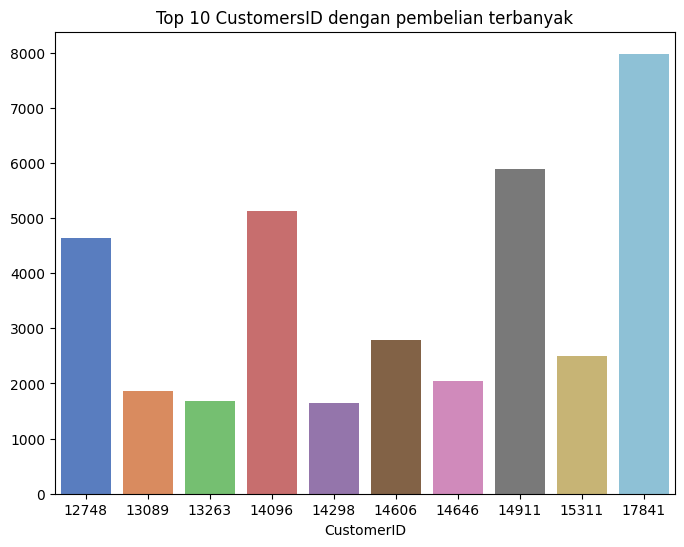

In [ ]:
customer_freq = df_final['CustomerID'].value_counts().nlargest(10)

plt.figure(figsize=(8,6))
sns.barplot(x=customer_freq.index, y=customer_freq.values, palette='muted')
plt.title('Top 10 CustomersID dengan pembelian terbanyak')

plt.show()

Berdasarkan plot diatas, didapat informasi sebagai berikut :
1. Pembeli dengan ID Customer “17841” telah melakukan pembelian terbanyak yakni berjumlah 8000
2. Pembelian terbanyak kedua dilakukan oleh customer dengan ID Customer “14911”
3. Pembeli dengan ID Customer “12748” dan “14096” melakukan pembelian sebanyak 4500 dan 5000 bertutut-turut
4. Sementara itu pembeli lainnya melakukan pembelian rata - rata sebanyak 1500 - 2500

Berdasarkan informasi diatas, didapat bahwa pembeli dengan ID customer “17841” melakukan pembelian terbanyak dan memiliki selisih jumlah pembelian yang cukup jauh jika dibandingkan dengan pembeli atau customer yang lain. Akan tetapi, karena pada tahap pre-processing didapat banyak missing value pada variabel “CustomerID” maka kita tidak bisa menarik kesimpulan pada kategorik ini. Hal ini disebabkan oleh visualisasi data tidak dapat mewakili kesimpulan yang sesungguhnya dari data yang diakibatkan oleh keberadaan missing value yang banyak.
Kita juga tidak dapat memberikan saran untuk mengoptimalkan penjualan karena kita tidak bisa mengambil kesimpulan dari visualisasi data yang telah diberikan.


-------------------------------------------------


# Market Basket Analysis

## Semua Bulan

In [ ]:
pip install mlxtend
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
df_customer = df_final['CustomerID' == 17850]
df_customer.head()

In [ ]:
# Filter data berdasarkan CustomerID 17850
filtered_invoice = df_final[df_final['CustomerID'] == 17850]

# Menghitung jumlah InvoiceNo unik
unique_invoices = filtered_invoice['InvoiceNo'].nunique()

# Menampilkan hasil
print(f"Jumlah InvoiceNo unik: {unique_invoices}")

Jumlah InvoiceNo unik: 35


Kami ingin melihat contoh pelanggan dengan CustomerID = 17850. Ternyata, pelanggan ini telah melakukan 35 transaksi dalam periode waktu yang tercatat dalam data. Hal ini menunjukkan bahwa setiap pelanggan dapat melakukan lebih dari satu transaksi selama rentang waktu tertentu. Oleh karena itu, akan lebih baik jika pelanggan dikelompokkan berdasarkan jumlah transaksi yang dilakukan.

In [ ]:
# Mengelompokkan barang berdasarkan transaksi
transactions = df_final.groupby(['InvoiceNo', 'Description'])['Quantity'].sum()
transactions.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InvoiceNo  Description                        
536365     Cream Cupid Hearts Coat Hanger          8
           Glass Star Frosted T-Light Holder       6
           Knitted Union Flag Hot Water Bottle     6
           Red Woolly Hottie White Heart.          6
           Set 7 Babushka Nesting Boxes            2
           White Hanging Heart T-Light Holder      6
           White Metal Lantern                     6
536366     Hand Warmer Red Retrospot               6
           Hand Warmer Union Jack                  6
536367     Assorted Colour Bird Ornament          32
           Box Of 6 Assorted Colour Teaspoons      6
           Box Of Vintage Alphabet Blocks          2
           Box Of Vintage Jigsaw Blocks            3
           Doormat New England                     4
           Feltcraft Princess Charlotte Doll       8
           Home Building Block Word                3
           Ivory Knitted Mug Cosy                  6
           Love Building Block Word                3
           Poppy'S Playhouse Bedroom               6
           Poppy'S Playhouse Kitchen               6
Name: Quantity, dtype: int64

Dari sini, kita dapat melihat bahwa setiap transaksi terdiri dari beberapa barang yang dibeli secara bersamaan, dengan kuantitas yang bervariasi.

In [ ]:
# Menampilkan barang-barang berdasarkan transaksi dalam bentuk list

basket = df_final.groupby(['CustomerID', 'InvoiceNo'])['Description'].apply(lambda x: '(' + ','.join(x) + ')').reset_index()
pd.set_option('display.max_colwidth', None)
basket.index.name = 'CustomerID'
basket.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CustomerID,InvoiceNo,Description
CustomerID,,,
0,12347,537626,"(Black Candelabra T-Light Holder,Airline Bag Vintage Jet Set Brown,Colour Glass. Star T-Light Holder,Mini Paint Set Vintage ,Clear Drawer Knob Acrylic Edwardian,Pink Drawer Knob Acrylic Edwardian,Green Drawer Knob Acrylic Edwardian,Red Drawer Knob Acrylic Edwardian,Purple Drawerknob Acrylic Edwardian,Blue Drawer Knob Acrylic Edwardian,Alarm Clock Bakelike Chocolate,Alarm Clock Bakelike Green,Alarm Clock Bakelike Red ,Alarm Clock Bakelike Pink,Alarm Clock Bakelike Orange,Four Hook White Lovebirds,Black Grand Baroque Photo Frame,Bathroom Metal Sign ,Large Heart Measuring Spoons,Box Of 6 Assorted Colour Teaspoons,Childrens Cutlery Polkadot Blue,Childrens Cutlery Retrospot Red ,Childrens Cutlery Polkadot Pink,Emergency First Aid Tin ,Set Of 2 Tins Vintage Bathroom ,Set/3 Decoupage Stacking Tins,Boom Box Speaker Boys,Red Toadstool Led Night Light,3D Dog Picture Playing Cards,Black Ear Muff Headphones,Camouflage Ear Muff Headphones)"
1,12347,542237,"(Pink New Baroquecandlestick Candle,Blue New Baroque Candlestick Candle,Black Candelabra T-Light Holder,Woodland Charlotte Bag,Airline Bag Vintage Jet Set Brown,Airline Bag Vintage Jet Set White,Sandwich Bath Sponge,Alarm Clock Bakelike Chocolate,Alarm Clock Bakelike Green,Alarm Clock Bakelike Red ,Alarm Clock Bakelike Pink,Alarm Clock Bakelike Orange,Small Heart Measuring Spoons,72 Sweetheart Fairy Cake Cases,60 Teatime Fairy Cake Cases,Pack Of 60 Mushroom Cake Cases,Pack Of 60 Spaceboy Cake Cases,Tea Time Oven Glove,Red Retrospot Oven Glove ,Red Retrospot Oven Glove Double,Set/2 Red Retrospot Tea Towels ,Regency Cakestand 3 Tier,Box Of 6 Assorted Colour Teaspoons,Mini Ladle Love Heart Red ,Chocolate Calculator,Toothpaste Tube Pen,Set Of 2 Tins Vintage Bathroom ,Red Toadstool Led Night Light,3D Dog Picture Playing Cards)"
2,12347,549222,"(Airline Bag Vintage Jet Set White,Airline Bag Vintage Jet Set Red,Airline Bag Vintage Tokyo 78,Airline Bag Vintage Jet Set Brown,Red Retrospot Purse ,Ice Cream Sundae Lip Gloss,Vintage Heads And Tails Card Game ,Holiday Fun Ludo,Treasure Island Book Box,Watering Can Pink Bunny,Red Drawer Knob Acrylic Edwardian,Large Heart Measuring Spoons,Small Heart Measuring Spoons,Pack Of 60 Dinosaur Cake Cases,Red Retrospot Oven Glove Double,Regency Cakestand 3 Tier,Roses Regency Teacup And Saucer ,Red Toadstool Led Night Light,Mini Paint Set Vintage ,3D Sheet Of Dog Stickers,3D Sheet Of Cat Stickers,Small Folding Scissor(Pointed Edge),Gift Bag Psychedelic Apples,Set Of 2 Tins Vintage Bathroom )"
3,12347,556201,"(Rabbit Night Light,Regency Tea Strainer,Regency Tea Plate Green ,Regency Tea Plate Pink,Regency Tea Plate Roses ,Regency Teapot Roses ,Regency Sugar Bowl Green,Regency Milk Jug Pink ,Airline Bag Vintage Tokyo 78,Airline Bag Vintage Jet Set Brown,Victorian Sewing Kit,Namaste Swagat Incense,Triple Hook Antique Ivory Rose,Small Heart Measuring Spoons,3D Dog Picture Playing Cards,Feather Pen,Coal Black,Alarm Clock Bakelike Red ,Alarm Clock Bakelike Chocolate)"
4,12347,562032,"(Set Of 60 Vintage Leaf Cake Cases ,Set 40 Heart Shape Petit Four Cases,Airline Bag Vintage Jet Set Brown,Airline Bag Vintage Jet Set Red,Airline Bag Vintage Jet Set White,Airline Bag Vintage Tokyo 78,Airline Bag Vintage World Champion ,Woodland Design Cotton Tote Bag,Woodland Charlotte Bag,Alarm Clock Bakelike Red ,Triple Hook Antique Ivory Rose,Single Antique Rose Hook Ivory,Tea Time Oven Glove,72 Sweetheart Fairy Cake Cases,60 Teatime Fairy Cake Cases,Pack Of 60 Dinosaur Cake Cases,Regency Cakestand 3 Tier,Regency Milk Jug Pink ,3D Dog Picture Playing Cards,Revolver Wooden Ruler ,Vintage Heads And Tails Card Game ,Red Refectory Clock )"


Berikut output berisi deskripsi semua barang yang dibeli dalam satu transaksi, disajikan dalam bentuk string panjang yang dipisahkan oleh koma:

In [ ]:
# Hitung frekuensi kemunculan tiap item
freq_basket = Counter(df_final['Description'])

# Ambil 20 item terbanyak
top_20_itemsets = freq_basket.most_common(20)

# Tampilkan hasil
print("20 item terbanyak:")
for item, count in top_20_itemsets:
    print(f"{item}: {count} kali")

20 item terbanyak:
White Hanging Heart T-Light Holder: 2064 kali
Regency Cakestand 3 Tier: 1905 kali
Jumbo Bag Red Retrospot: 1654 kali
Party Bunting: 1416 kali
Assorted Colour Bird Ornament: 1414 kali
Lunch Bag Red Retrospot: 1359 kali
Set Of 3 Cake Tins Pantry Design : 1231 kali
Postage: 1196 kali
Lunch Bag  Black Skull.: 1126 kali
Jumbo Bag Vintage Doily : 1113 kali
Lunch Bag Suki Design : 1103 kali
Popcorn Holder: 1095 kali
Pack Of 72 Retrospot Cake Cases: 1070 kali
Lunch Bag Vintage Doily : 1040 kali
Spotty Bunting: 1036 kali
Paper Chain Kit 50'S Christmas : 1026 kali
Lunch Bag Spaceboy Design : 1021 kali
Lunch Bag Cars Blue: 1012 kali
Natural Slate Heart Chalkboard : 996 kali
Heart Of Wicker Small: 988 kali


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Karena kompleksitas yang ada, kami memutuskan untuk hanya mengambil 20 item dengan jumlah pembelian terbanyak. Langkah ini bertujuan untuk menyederhanakan analisis dan interpretasi data, sehingga lebih mudah dipahami. Dengan membatasi fokus pada item-item yang paling populer, kita dapat lebih efektif dalam mengidentifikasi tren pembelian dan perilaku konsumen.

In [ ]:
# Ambil 20 item teratas dari hasil frekuensi sebelumnya
top_items = [item for item, count in top_20_itemsets]

# Group by InvoiceNo dan Description
basket_encode = df_final.groupby(['InvoiceNo'])['Description'].apply(lambda x: ','.join(x)).reset_index()

# One-Hot Encoding untuk 20 item teratas
for item in top_items:
    basket_encode[item] = basket_encode['Description'].apply(lambda x: 1 if item in x else 0)

# Hapus kolom 'Description' dan 'InvoiceNo'
basket_encode = basket_encode.drop(columns=['Description', 'InvoiceNo']) # Drop 'InvoiceNo' column

# Tampilkan hasil
basket_encode.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,White Hanging Heart T-Light Holder,Regency Cakestand 3 Tier,Jumbo Bag Red Retrospot,Party Bunting,Assorted Colour Bird Ornament,Lunch Bag Red Retrospot,Set Of 3 Cake Tins Pantry Design,Postage,Lunch Bag Black Skull.,Jumbo Bag Vintage Doily,Lunch Bag Suki Design,Popcorn Holder,Pack Of 72 Retrospot Cake Cases,Lunch Bag Vintage Doily,Spotty Bunting,Paper Chain Kit 50'S Christmas,Lunch Bag Spaceboy Design,Lunch Bag Cars Blue,Natural Slate Heart Chalkboard,Heart Of Wicker Small
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Melihat support masing-masing itemsets

frequent_itemsets = apriori(basket_encode, min_support=0.01, use_colnames=True)
pd.set_option('display.max_rows', None)
frequent_itemsets = pd.DataFrame(frequent_itemsets)
frequent_itemsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.091215,(White Hanging Heart T-Light Holder)
1,0.085625,(Regency Cakestand 3 Tier)
2,0.074308,(Jumbo Bag Red Retrospot)
3,0.070536,(Party Bunting)
4,0.062764,(Assorted Colour Bird Ornament)
5,0.060446,(Lunch Bag Red Retrospot)
6,0.055311,(Set Of 3 Cake Tins Pantry Design )
7,0.054993,(Postage)
8,0.048766,(Lunch Bag Black Skull.)
9,0.049766,(Jumbo Bag Vintage Doily )


In [ ]:
# Penetapan Association Rules

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values(by='lift', ascending=False, na_position='last', inplace = True)
rules.head(100)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
126,(Lunch Bag Suki Design ),"(Lunch Bag Spaceboy Design , Lunch Bag Cars Blue)",0.048312,0.017952,0.010953,0.226717,12.628989,0.010086,1.269972,0.967562
123,"(Lunch Bag Spaceboy Design , Lunch Bag Cars Blue)",(Lunch Bag Suki Design ),0.017952,0.048312,0.010953,0.610127,12.628989,0.010086,2.441019,0.937650
108,(Lunch Bag Suki Design ),"(Lunch Bag Spaceboy Design , Lunch Bag Black Skull.)",0.048312,0.019043,0.011453,0.237065,12.449020,0.010533,1.285767,0.966359
105,"(Lunch Bag Spaceboy Design , Lunch Bag Black Skull.)",(Lunch Bag Suki Design ),0.019043,0.048312,0.011453,0.601432,12.449020,0.010533,2.387769,0.937526
96,(Lunch Bag Suki Design ),"(Lunch Bag Red Retrospot, Lunch Bag Cars Blue)",0.048312,0.021179,0.012635,0.261524,12.348310,0.011611,1.325461,0.965670
93,"(Lunch Bag Red Retrospot, Lunch Bag Cars Blue)",(Lunch Bag Suki Design ),0.021179,0.048312,0.012635,0.596567,12.348310,0.011611,2.358972,0.938902
113,(Lunch Bag Suki Design ),"(Lunch Bag Black Skull., Lunch Bag Cars Blue)",0.048312,0.019316,0.011453,0.237065,12.273269,0.010520,1.285410,0.965150
112,"(Lunch Bag Black Skull., Lunch Bag Cars Blue)",(Lunch Bag Suki Design ),0.019316,0.048312,0.011453,0.592941,12.273269,0.010520,2.337963,0.936613
91,(Lunch Bag Suki Design ),"(Lunch Bag Red Retrospot, Lunch Bag Spaceboy Design )",0.048312,0.021361,0.012407,0.256820,12.023016,0.011375,1.316827,0.963368
86,"(Lunch Bag Red Retrospot, Lunch Bag Spaceboy Design )",(Lunch Bag Suki Design ),0.021361,0.048312,0.012407,0.580851,12.023016,0.011375,2.270526,0.936838


1. Bundling (Lunch Bag Suki DesignLunch Bag Spaceboy Design , Lunch Bag Cars Blue)

## September - Desember

Berdasarkan grafik yang ditampilkan, terlihat bahwa penjualan mengalami peningkatan, terutama pada bulan November. Akan diperiksa juga terkait apa yang sudah dilihat di EDA

In [ ]:
# Filter data untuk bulan September hingga Desember
df_final2 = df[(df['InvoiceDate'].dt.month >= 9) & (df['InvoiceDate'].dt.month <= 12)]

# Menampilkan data yang terfilter
df_final2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,White Hanging Heart T-Light Holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,White Metal Lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,Cream Cupid Hearts Coat Hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,Knitted Union Flag Hot Water Bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,Red Woolly Hottie White Heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [ ]:
# Pengelompokkan barang berdasarkan transaksi
transactions2 = df_final2.groupby(['InvoiceNo', 'Description'])['Quantity'].sum()
transactions2.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InvoiceNo  Description                        
536365     Cream Cupid Hearts Coat Hanger          8
           Glass Star Frosted T-Light Holder       6
           Knitted Union Flag Hot Water Bottle     6
           Red Woolly Hottie White Heart.          6
           Set 7 Babushka Nesting Boxes            2
           White Hanging Heart T-Light Holder      6
           White Metal Lantern                     6
536366     Hand Warmer Red Retrospot               6
           Hand Warmer Union Jack                  6
536367     Assorted Colour Bird Ornament          32
           Box Of 6 Assorted Colour Teaspoons      6
           Box Of Vintage Alphabet Blocks          2
           Box Of Vintage Jigsaw Blocks            3
           Doormat New England                     4
           Feltcraft Princess Charlotte Doll       8
           Home Building Block Word                3
           Ivory Knitted Mug Cosy                  6
           Love Building Block Word                3
           Poppy'S Playhouse Bedroom               6
           Poppy'S Playhouse Kitchen               6
Name: Quantity, dtype: int64

In [ ]:
# Menampilkan barang-barang berdasarkan transaksi dalam bentuk list

basket2 = df_final2.groupby(['CustomerID', 'InvoiceNo'])['Description'].apply(lambda x: '(' + ','.join(x) + ')').reset_index()
pd.set_option('display.max_colwidth', None)

basket2.index.name = 'CustomerID'
basket2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CustomerID,InvoiceNo,Description
CustomerID,,,
0,12347,537626,"(Black Candelabra T-Light Holder,Airline Bag Vintage Jet Set Brown,Colour Glass. Star T-Light Holder,Mini Paint Set Vintage ,Clear Drawer Knob Acrylic Edwardian,Pink Drawer Knob Acrylic Edwardian,Green Drawer Knob Acrylic Edwardian,Red Drawer Knob Acrylic Edwardian,Purple Drawerknob Acrylic Edwardian,Blue Drawer Knob Acrylic Edwardian,Alarm Clock Bakelike Chocolate,Alarm Clock Bakelike Green,Alarm Clock Bakelike Red ,Alarm Clock Bakelike Pink,Alarm Clock Bakelike Orange,Four Hook White Lovebirds,Black Grand Baroque Photo Frame,Bathroom Metal Sign ,Large Heart Measuring Spoons,Box Of 6 Assorted Colour Teaspoons,Childrens Cutlery Polkadot Blue,Childrens Cutlery Retrospot Red ,Childrens Cutlery Polkadot Pink,Emergency First Aid Tin ,Set Of 2 Tins Vintage Bathroom ,Set/3 Decoupage Stacking Tins,Boom Box Speaker Boys,Red Toadstool Led Night Light,3D Dog Picture Playing Cards,Black Ear Muff Headphones,Camouflage Ear Muff Headphones)"
1,12347,573511,"(Mini Lights Woodland Mushrooms,Pink Goose Feather Tree 60Cm,Madras Notebook Medium,Airline Bag Vintage World Champion ,Airline Bag Vintage Jet Set Brown,Airline Bag Vintage Tokyo 78,Airline Bag Vintage Jet Set Red,Birdcage Decoration Tealight Holder,Christmas Metal Tags Assorted ,Regency Cakestand 3 Tier,Regency Teapot Roses ,Tea Time Des Tea Cosy,Tea Time Kitchen Apron,Tea Time Oven Glove,Pink Regency Teacup And Saucer,Green Regency Teacup And Saucer,3D Dog Picture Playing Cards,Rabbit Night Light,Red Toadstool Led Night Light,Treasure Island Book Box,Vintage Heads And Tails Card Game ,Mini Playing Cards Dolly Girl ,Mini Playing Cards Spaceboy ,Playing Cards Keep Calm & Carry On,Revolver Wooden Ruler ,Wooden School Colouring Set,Mini Paint Set Vintage ,Traditional Knitting Nancy,Triple Hook Antique Ivory Rose,Pantry Hook Spatula,Pantry Hook Balloon Whisk ,Pantry Hook Tea Strainer ,Roses Regency Teacup And Saucer ,Alarm Clock Bakelike Chocolate,Alarm Clock Bakelike Pink,Alarm Clock Bakelike Green,Alarm Clock Bakelike Red ,Pack Of 60 Mushroom Cake Cases,Pack Of 60 Spaceboy Cake Cases,Set Of 60 Vintage Leaf Cake Cases ,60 Teatime Fairy Cake Cases,72 Sweetheart Fairy Cake Cases,Small Heart Measuring Spoons,Large Heart Measuring Spoons,Woodland Charlotte Bag,Regency Tea Strainer,Food Container Set 3 Love Heart )"
2,12347,581180,"(Classic Chrome Bicycle Bell ,Bicycle Puncture Repair Kit ,Boom Box Speaker Boys,Pink New Baroquecandlestick Candle,Red Toadstool Led Night Light,Rabbit Night Light,Woodland Charlotte Bag,Pink Goose Feather Tree 60Cm,Christmas Table Silver Candle Spike,Mini Playing Cards Spaceboy ,Mini Playing Cards Dolly Girl )"
3,12348,539318,"(72 Sweetheart Fairy Cake Cases,60 Cake Cases Dolly Girl Design,60 Teatime Fairy Cake Cases,60 Teatime Fairy Cake Cases,Pack Of 72 Skull Cake Cases,Pack Of 72 Skull Cake Cases,Pack Of 12 London Tissues ,Pack Of 12 Woodland Tissues ,Pack Of 12 Suki Tissues ,Sweeties Stickers,Set Of 72 Skull Paper Doilies,Set Of 72 Pink Heart Paper Doilies,60 Cake Cases Vintage Christmas,60 Cake Cases Vintage Christmas,Pack Of 60 Pink Paisley Cake Cases,Pack Of 60 Pink Paisley Cake Cases,Postage)"
4,12348,568172,"(Doughnut Lip Gloss ,Ice Cream Pen Lip Gloss ,Postage)"


In [ ]:
# Hitung frekuensi kemunculan tiap item
freq_basket2 = Counter(df_final2['Description'])

# Ambil 20 item terbanyak
top_20_itemsets2 = freq_basket2.most_common(20)

# Tampilkan hasil
print("20 item terbanyak dibeli:")
for item, count in top_20_itemsets2:
    print(f"{item}: {count} kali")

20 item terbanyak dibeli:
Paper Chain Kit 50'S Christmas : 963 kali
White Hanging Heart T-Light Holder: 829 kali
Hot Water Bottle Keep Calm: 732 kali
Jumbo Bag Red Retrospot: 719 kali
Regency Cakestand 3 Tier: 700 kali
Paper Chain Kit Vintage Christmas: 678 kali
Rabbit Night Light: 661 kali
Assorted Colour Bird Ornament: 629 kali
Chocolate Hot Water Bottle: 598 kali
Popcorn Holder: 595 kali
Hand Warmer Owl Design: 573 kali
Scottie Dog Hot Water Bottle: 566 kali
Jumbo Bag Vintage Doily : 551 kali
Postage: 547 kali
Jumbo Bag 50'S Christmas : 538 kali
Rex Cash+Carry Jumbo Shopper: 536 kali
Hot Water Bottle Tea And Sympathy: 510 kali
Hand Warmer Scotty Dog Design: 490 kali
Set Of 20 Vintage Christmas Napkins: 487 kali
Lunch Bag Red Retrospot: 484 kali


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dari sini dilihat bahwa item terbanyak yang dibeli adalah dekorasi Paper Chain Kit, gantungan lilin, dan botol air panas.

In [ ]:
# Ambil 20 item teratas dari hasil frekuensi sebelumnya
top_items2 = [item for item, count in top_20_itemsets2]

# Group by InvoiceNo dan Description
basket_encode2 = df_final2.groupby(['InvoiceNo'])['Description'].apply(lambda x: ','.join(x)).reset_index()

# One-Hot Encoding untuk 20 item teratas
for item in top_items2:
    basket_encode2[item] = basket_encode2['Description'].apply(lambda x: 1 if item in x else 0)

# Hapus kolom 'Description' DAN 'InvoiceNo'
basket_encode2 = basket_encode2.drop(columns=['Description', 'InvoiceNo']) # Drop 'InvoiceNo' column

# Tampilkan hasil
basket_encode2.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Paper Chain Kit 50'S Christmas,White Hanging Heart T-Light Holder,Hot Water Bottle Keep Calm,Jumbo Bag Red Retrospot,Regency Cakestand 3 Tier,Paper Chain Kit Vintage Christmas,Rabbit Night Light,Assorted Colour Bird Ornament,Chocolate Hot Water Bottle,Popcorn Holder,Hand Warmer Owl Design,Scottie Dog Hot Water Bottle,Jumbo Bag Vintage Doily,Postage,Jumbo Bag 50'S Christmas,Rex Cash+Carry Jumbo Shopper,Hot Water Bottle Tea And Sympathy,Hand Warmer Scotty Dog Design,Set Of 20 Vintage Christmas Napkins,Lunch Bag Red Retrospot
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Melihat support masing-masing itemsets

frequent_itemsets2 = apriori(basket_encode2, min_support=0.01, use_colnames=True)
pd.set_option('display.max_rows', None)
frequent_itemsets2 = pd.DataFrame(frequent_itemsets2)
frequent_itemsets2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.092084,(Paper Chain Kit 50'S Christmas )
1,0.079654,(White Hanging Heart T-Light Holder)
2,0.070704,(Hot Water Bottle Keep Calm)
3,0.070207,(Jumbo Bag Red Retrospot)
4,0.068317,(Regency Cakestand 3 Tier)
5,0.065831,(Paper Chain Kit Vintage Christmas)
6,0.061854,(Rabbit Night Light)
7,0.060660,(Assorted Colour Bird Ornament)
8,0.058274,(Chocolate Hot Water Bottle)
9,0.057478,(Popcorn Holder)


Banyak kebutuhan untuk Natal dibeli secara bersamaan, terutama perlengkapan dekorasi. Jika kita mempertimbangkan seluruh tahun, nilai support untuk kategori ini tidak setinggi yang terlihat selama musim Natal. Ini menunjukkan bahwa pembelian bersifat musiman, tetapi tetap banyak dilakukan.

Dengan momentum ini, sebaiknya kita memanfaatkan peluang untuk meraih keuntungan maksimal. Optimalisasi promosi dan ketersediaan barang harus disesuaikan berdasarkan item yang paling sering dibeli. Penjelasan lebih lanjut akan disusun untuk mendukung hal ini.

In [ ]:
# Penetapan Association Rules

rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)
rules2.sort_values(by='lift', ascending=False, na_position='last', inplace = True)
rules2.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
62,"(Hot Water Bottle Keep Calm, Chocolate Hot Water Bottle)",(Hot Water Bottle Tea And Sympathy),0.024264,0.050119,0.014519,0.598361,11.938720,0.013303,2.365009,0.939024
67,(Hot Water Bottle Tea And Sympathy),"(Hot Water Bottle Keep Calm, Chocolate Hot Water Bottle)",0.050119,0.024264,0.014519,0.289683,11.938720,0.013303,1.373662,0.964583
66,(Chocolate Hot Water Bottle),"(Hot Water Bottle Keep Calm, Hot Water Bottle Tea And Sympathy)",0.058274,0.022673,0.014519,0.249147,10.988683,0.013197,1.301622,0.965246
63,"(Hot Water Bottle Keep Calm, Hot Water Bottle Tea And Sympathy)",(Chocolate Hot Water Bottle),0.022673,0.058274,0.014519,0.640351,10.988683,0.013197,2.618459,0.930085
46,(Hand Warmer Scotty Dog Design),(Hand Warmer Owl Design),0.045644,0.054793,0.026850,0.588235,10.735561,0.024349,2.295502,0.950224
47,(Hand Warmer Owl Design),(Hand Warmer Scotty Dog Design),0.054793,0.045644,0.026850,0.490018,10.735561,0.024349,1.871352,0.959421
57,"(Set Of 20 Vintage Christmas Napkins, Paper Chain Kit 50'S Christmas )",(Paper Chain Kit Vintage Christmas),0.016309,0.065831,0.010044,0.615854,9.355022,0.008970,2.431804,0.907912
60,(Paper Chain Kit Vintage Christmas),"(Set Of 20 Vintage Christmas Napkins, Paper Chain Kit 50'S Christmas )",0.065831,0.016309,0.010044,0.152568,9.355022,0.008970,1.160791,0.956043
42,(Chocolate Hot Water Bottle),(Hot Water Bottle Tea And Sympathy),0.058274,0.050119,0.025557,0.438567,8.750447,0.022636,1.691885,0.940528
43,(Hot Water Bottle Tea And Sympathy),(Chocolate Hot Water Bottle),0.050119,0.058274,0.025557,0.509921,8.750447,0.022636,1.921579,0.932454


Item seperti "Hot Water Bottle Keep Calm", "Chocolate Hot Water Bottle", "Hot Water Bottle Tea And Sympathy" menunjukkan nilai lift yang tinggi sebesar 11.94, menunjukkan bahwa jika pelanggan membeli salah satu dari tiga item tersebut, ada kemungkinan besar mereka juga akan membeli item lainnya.

# Rekomendasi dan Kesimpulan

Rekomendasi yang dapat diberikan kepada pemilik perusahaan agar penjualannya dapat mendapatkan untung yang maksimal adalah sebagai berikut:
1. Mempertahankan atau bahkan meningkatkan stok produk terlaris seperti “White Hanging Heart T-Light Holder” dan “Regency Cakestand 3 Tier”.
2. Meningkatkan promosi untuk produk dengan penjualan lebih rendah seperti “Heart Of Wicker Small” dan “Natural Slate Heart Chalkboard”.
3. Untuk item tas makan, tingkatkan penjualan item yang masih kurang diminati seperti “Lunch Bag Spaceboy Design” dan “Lunch Bag Cars Blue” dengan memberikan diskon atau tawaran membeli tas makan “Spaceboy Design” bisa mendapat “Cars Blue”.
4. Fokus pada produk dengan pendapatan tertinggi, seperti “Manual” dan “Regency Cakestand 3 Tier”, sambil mengoptimalkan produk berpendapatan rendah melalui bundling atau promosi khusus.
5. Strategi penjualan musiman yaitu fokuskan promosi pada akhir tahun (November-Desember), dan gunakan kampanye diskon di pertengahan tahun untuk menjaga penjualan yang lebih stabil.
6. Tingkatkan stok di negara dengan penjualan tinggi, khususnya United Kingdom, serta pertimbangkan promosi dan pemasaran yang lebih intens di negara dengan penjualan rendah seperti Spanyol dan Australia.
